In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures


In [2]:
df_face = pd.read_csv('/content/Face.csv')
df_neigh_face= pd.read_csv('/content/NeighFace.csv')
df_neigh_radius= pd.read_csv('/content/NeighRadius.csv')
df_radius = pd.read_csv('/content/Radius.csv')

In [3]:
df_face

,Unnamed: 0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t1873,t1874,t1875,t1876,t1877,t1878,t1879,t1880,t1881,t1882
0,g1,16,16,16,16,16,16,16,16,16,...,0,0,0,0,0,0,0,0,0,0
1,g2,28,27,27,27,25,25,25,25,25,...,21,21,21,21,21,21,21,21,21,21
2,g3,16,16,16,16,16,16,16,16,16,...,0,0,0,0,0,0,0,0,0,0
3,g4,13,13,13,12,12,12,12,12,12,...,0,0,0,0,0,0,0,0,0,0
4,g5,12,12,12,12,12,12,12,12,12,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,g4996,18,18,18,18,18,18,18,18,18,...,0,0,0,0,0,0,0,0,0,0
4996,g4997,26,26,26,26,26,26,26,26,26,...,16,16,16,16,16,16,16,16,16,16
4997,g4998,14,12,12,13,13,14,13,13,13,...,0,0,0,0,0,0,0,0,0,0
4998,g4999,20,20,20,20,20,20,20,20,20,...,0,0,0,0,0,0,0,0,0,0


In [4]:
columns_to_keep = ['Unnamed: 0'] + [f't{i}' for i in range(500, 1000)]

In [5]:
df_face_filtered = df_face[columns_to_keep]
df_neigh_face_filtered = df_neigh_face[columns_to_keep]
df_neigh_radius_filtered = df_neigh_radius[columns_to_keep]
df_radius_filtered = df_radius[columns_to_keep]

In [6]:
df_face_filtered

,Unnamed: 0,t500,t501,t502,t503,t504,t505,t506,t507,t508,...,t990,t991,t992,t993,t994,t995,t996,t997,t998,t999
0,g1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,g2,26,26,26,26,26,26,26,26,26,...,22,22,22,22,22,22,22,22,22,22
2,g3,8,8,8,8,8,8,8,8,8,...,0,0,0,0,0,0,0,0,0,0
3,g4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,g5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,g4996,14,14,14,14,14,14,14,14,14,...,0,0,0,0,0,0,0,0,0,0
4996,g4997,21,21,21,21,21,21,21,21,21,...,20,20,20,20,20,20,20,20,20,20
4997,g4998,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,g4999,15,15,15,15,15,15,15,15,15,...,12,13,13,13,13,13,13,13,13,13


In [7]:
# Initialize lists to store metrics
avg_rmse_train = []
avg_rmse_test = []
avg_r2_train = []
avg_r2_test = []
equations = []

In [8]:
timeframes = [f't{i}' for i in range(500, 1000)]

In [9]:
for timeframe in timeframes:
    # Merging dataframes as per the specific timeframe
    df_merged = df_radius_filtered[['Unnamed: 0', timeframe]].rename(columns={timeframe: 'Radius'})
    df_merged = df_merged.merge(df_face_filtered[['Unnamed: 0', timeframe]], on='Unnamed: 0').rename(columns={timeframe: 'Face'})
    df_merged = df_merged.merge(df_neigh_radius_filtered[['Unnamed: 0', timeframe]], on='Unnamed: 0').rename(columns={timeframe: 'NeighRadius'})
    df_merged = df_merged.merge(df_neigh_face_filtered[['Unnamed: 0', timeframe]], on='Unnamed: 0').rename(columns={timeframe: 'NeighFace'})

    X = df_merged[['Face', 'NeighRadius', 'NeighFace']]
    y = df_merged['Radius']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Define a pipeline with StandardScaler, PolynomialFeatures, and ElasticNet with specific parameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('elasticnet', ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=42))
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Calculate and store metrics
    avg_rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    avg_rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    avg_r2_train.append(r2_score(y_train, y_train_pred))
    avg_r2_test.append(r2_score(y_test, y_test_pred))

    # Store the equation coefficients
    coef = pipeline.named_steps['elasticnet'].coef_
    intercept = pipeline.named_steps['elasticnet'].intercept_
    equation = f"Radius = {intercept:.4f} + {coef[1]:.4f}*Face + {coef[2]:.4f}*NeighRadius + {coef[3]:.4f}*NeighFace"
    equations.append(equation)


In [10]:
# Output average metrics and equations
print(f"Average RMSE Train: {np.mean(avg_rmse_train)}")
print(f"Average RMSE Test: {np.mean(avg_rmse_test)}")
print(f"Average R² Train: {np.mean(avg_r2_train)}")
print(f"Average R² Test: {np.mean(avg_r2_test)}")

Average RMSE Train: 0.9949957032439593
Average RMSE Test: 1.0043952991300233
Average R² Train: 0.981005527620104
Average R² Test: 0.9804107387415458


In [11]:
for eq in equations:
    print(eq)

Radius = 4.8407 + 5.6245*Face + 0.9613*NeighRadius + 0.0000*NeighFace
Radius = 4.8144 + 5.5980*Face + 0.9817*NeighRadius + 0.0000*NeighFace
Radius = 4.7895 + 5.5876*Face + 0.9876*NeighRadius + 0.0000*NeighFace
Radius = 4.7699 + 5.5785*Face + 0.9928*NeighRadius + 0.0000*NeighFace
Radius = 4.7566 + 5.5774*Face + 0.9924*NeighRadius + 0.0000*NeighFace
Radius = 4.7247 + 5.5559*Face + 1.0073*NeighRadius + 0.0000*NeighFace
Radius = 4.7195 + 5.5492*Face + 1.0109*NeighRadius + 0.0000*NeighFace
Radius = 4.6878 + 5.5264*Face + 1.0253*NeighRadius + 0.0000*NeighFace
Radius = 4.6290 + 5.4840*Face + 1.0542*NeighRadius + 0.0000*NeighFace
Radius = 4.6165 + 5.4704*Face + 1.0624*NeighRadius + 0.0000*NeighFace
Radius = 4.5804 + 5.4421*Face + 1.0808*NeighRadius + 0.0000*NeighFace
Radius = 4.6058 + 5.4771*Face + 1.0534*NeighRadius + 0.0000*NeighFace
Radius = 4.5733 + 5.4584*Face + 1.0648*NeighRadius + 0.0000*NeighFace
Radius = 4.5708 + 5.4611*Face + 1.0607*NeighRadius + 0.0000*NeighFace
Radius = 4.5515 + 5.

In [12]:
coefficients = []
for eq in equations:
    matches = re.findall(r'([-+]?\d*\.\d+|\d+)', eq)
    if matches and len(matches) >= 4:
        const = float(matches[0])  # Intercept
        face_coef = float(matches[1])  # Face coefficient
        neigh_radius_coef = float(matches[2])  # NeighRadius coefficient
        neigh_face_coef = float(matches[3])  # NeighFace coefficient
        coefficients.append({
            'Timestamp': timeframes[len(coefficients)],  # Assuming the timeframes align with the order
            'Constant': const,
            'Face': face_coef,
            'NeighRadius': neigh_radius_coef,
            'NeighFace': neigh_face_coef
        })

In [13]:
# Create a DataFrame from the coefficients
coefficients_df = pd.DataFrame(coefficients)

In [14]:
coefficients_df

,Timestamp,Constant,Face,NeighRadius,NeighFace
0,t500,4.8407,5.6245,0.9613,0.0000
1,t501,4.8144,5.5980,0.9817,0.0000
2,t502,4.7895,5.5876,0.9876,0.0000
3,t503,4.7699,5.5785,0.9928,0.0000
4,t504,4.7566,5.5774,0.9924,0.0000
...,...,...,...,...,...
495,t995,-0.3165,0.6812,0.6768,0.0535
496,t996,-0.3319,0.6785,0.6533,0.0554
497,t997,-0.3341,0.6601,0.6564,0.0662
498,t998,-0.3844,0.6489,0.6256,0.0298


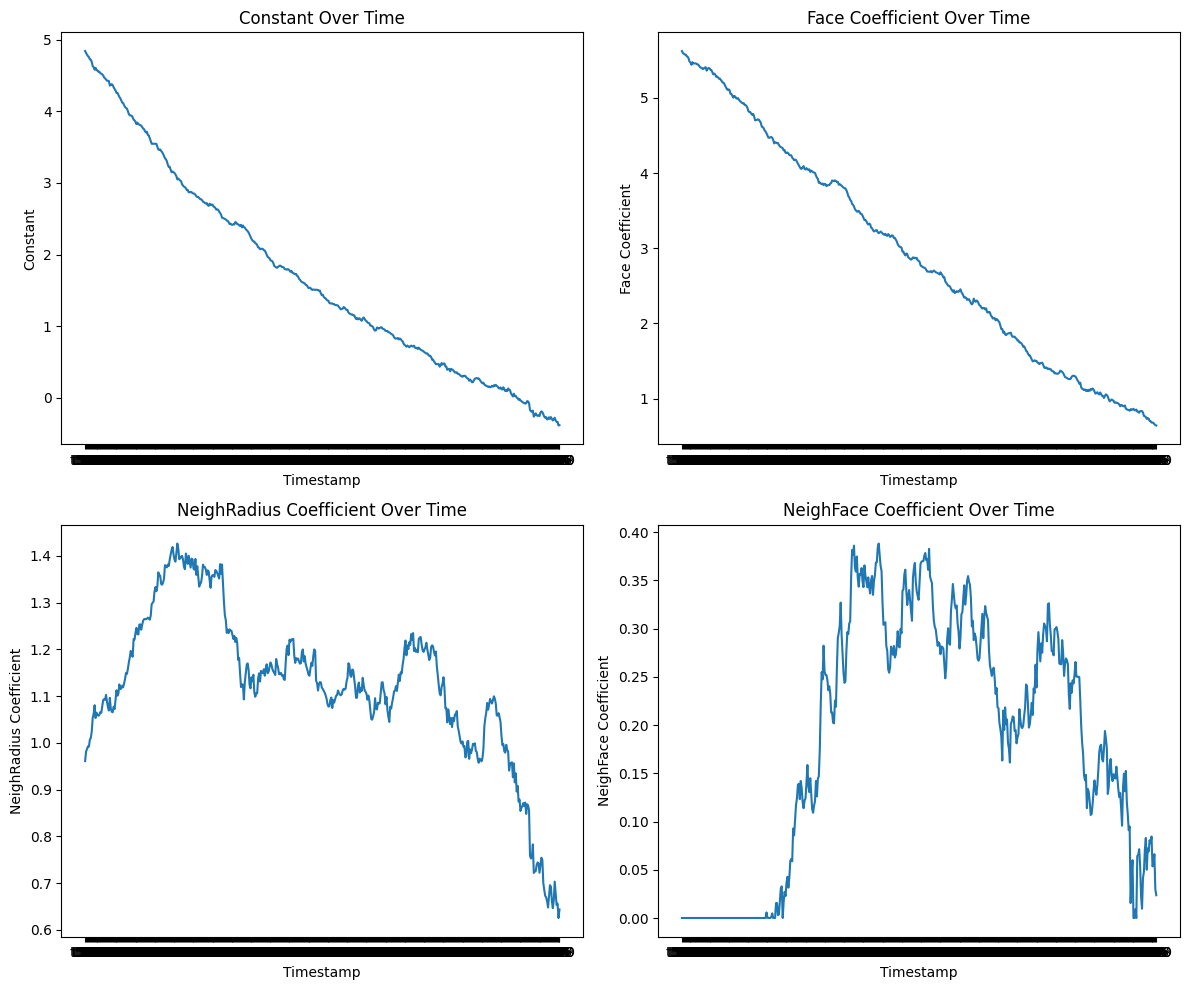

In [15]:
# Plotting the coefficients over time
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Constant plot
sns.lineplot(data=coefficients_df, x='Timestamp', y='Constant', ax=axs[0, 0])
axs[0, 0].set_title("Constant Over Time")
axs[0, 0].set_xlabel("Timestamp")
axs[0, 0].set_ylabel("Constant")

# Face coefficient plot
sns.lineplot(data=coefficients_df, x='Timestamp', y='Face', ax=axs[0, 1])
axs[0, 1].set_title("Face Coefficient Over Time")
axs[0, 1].set_xlabel("Timestamp")
axs[0, 1].set_ylabel("Face Coefficient")

# NeighRadius coefficient plot
sns.lineplot(data=coefficients_df, x='Timestamp', y='NeighRadius', ax=axs[1, 0])
axs[1, 0].set_title("NeighRadius Coefficient Over Time")
axs[1, 0].set_xlabel("Timestamp")
axs[1, 0].set_ylabel("NeighRadius Coefficient")

# NeighFace coefficient plot
sns.lineplot(data=coefficients_df, x='Timestamp', y='NeighFace', ax=axs[1, 1])
axs[1, 1].set_title("NeighFace Coefficient Over Time")
axs[1, 1].set_xlabel("Timestamp")
axs[1, 1].set_ylabel("NeighFace Coefficient")

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig("coefficients_over_time.jpg", format='jpg')

In [16]:
import plotly.express as px

In [17]:
import plotly.graph_objects as go

# Create the base figure
fig = go.Figure()

# Add scatter plots for each coefficient
fig.add_scatter(x=coefficients_df['Timestamp'], y=coefficients_df['Constant'], mode='lines+markers', name='Constant')
fig.add_scatter(x=coefficients_df['Timestamp'], y=coefficients_df['Face'], mode='lines+markers', name='Face Coefficient')
fig.add_scatter(x=coefficients_df['Timestamp'], y=coefficients_df['NeighRadius'], mode='lines+markers', name='NeighRadius Coefficient')
fig.add_scatter(x=coefficients_df['Timestamp'], y=coefficients_df['NeighFace'], mode='lines+markers', name='NeighFace Coefficient')

# Add titles and labels
fig.update_layout(
    title='Coefficient Values Over Time',
    xaxis_title='Timestamp',
    yaxis_title='Coefficient',
    legend_title='Coefficients',
    hovermode='x unified'  # Hover displays info for all subplots on a shared x-axis
)

# Show the interactive plot
fig.show()


In [18]:
# prompt: download coefficients_df

from google.colab import files

coefficients_df.to_csv('coefficients.csv')
files.download('coefficients.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
coefficients_data = pd.read_csv("/content/coefficients.csv")

In [20]:
coefficients_data

,Unnamed: 0,Timestamp,Constant,Face,NeighRadius,NeighFace
0,0,t500,4.8407,5.6245,0.9613,0.0000
1,1,t501,4.8144,5.5980,0.9817,0.0000
2,2,t502,4.7895,5.5876,0.9876,0.0000
3,3,t503,4.7699,5.5785,0.9928,0.0000
4,4,t504,4.7566,5.5774,0.9924,0.0000
...,...,...,...,...,...,...
495,495,t995,-0.3165,0.6812,0.6768,0.0535
496,496,t996,-0.3319,0.6785,0.6533,0.0554
497,497,t997,-0.3341,0.6601,0.6564,0.0662
498,498,t998,-0.3844,0.6489,0.6256,0.0298


In [21]:
coefficients_data['Time Index'] = coefficients_data['Timestamp'].str.extract('(\d+)').astype(int)

# Calculate the Face coefficient values using the regression equation
face_model_values = -0.0102 * coefficients_data['Time Index'] + 10.5703

# Create the base figure
fig = go.Figure()

# Add scatter plot for the actual Face data
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['Face'], mode='markers', name='Actual Face Data')

# Add line plot for the Face model
fig.add_scatter(x=coefficients_data['Timestamp'], y=face_model_values, mode='lines', name='Face Model Line')

# Add titles and labels
fig.update_layout(
    title='Face Coefficient and Regression Line',
    xaxis_title='Timestamp',
    yaxis_title='Face Coefficient',
    legend_title='Data',
    hovermode='x unified'  # Hover displays info for all subplots on a shared x-axis
)

# Show the interactive plot
fig.show()

In [22]:
constant_model_values = -0.0097 * coefficients_data['Time Index'] + 9.000

# Create the base figure
fig = go.Figure()

# Add scatter plot for the actual Constant data
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['Constant'], mode='markers', name='Actual Constant Data')

# Add line plot for the Constant model
fig.add_scatter(x=coefficients_data['Timestamp'], y=constant_model_values, mode='lines', name='Constant Model Line')

# Add titles and labels
fig.update_layout(
    title='Constant Coefficient and Regression Line',
    xaxis_title='Timestamp',
    yaxis_title='Constant Coefficient',
    legend_title='Data',
    hovermode='x unified'  # Hover displays info for all subplots on a shared x-axis
)

# Show the interactive plot
fig.show()

In [23]:
# Generate regression line values for Face and Constant
face_model_values = -0.0102 * coefficients_data['Time Index'] + 10.5703  # Update with actual coefficients
constant_model_values = -0.0097 * coefficients_data['Time Index'] + 9.000  # Update with actual coefficients

# Create the base figure
fig = go.Figure()

# Add scatter plots for each actual coefficient
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['Constant'], mode='markers', name='Actual Constant Data')
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['Face'], mode='markers', name='Actual Face Data')
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['NeighRadius'], mode='markers', name='Actual NeighRadius Data')
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['NeighFace'], mode='markers', name='Actual NeighFace Data')

# Add regression line plots
fig.add_scatter(x=coefficients_data['Timestamp'], y=constant_model_values, mode='lines', name='Constant Model Line')
fig.add_scatter(x=coefficients_data['Timestamp'], y=face_model_values, mode='lines', name='Face Model Line')

# Add titles and labels
fig.update_layout(
    title='Coefficient Values Over Time',
    xaxis_title='Timestamp',
    yaxis_title='Coefficient',
    legend_title='Coefficients',
    hovermode='x unified'  # Hover displays info for all subplots on a shared x-axis
)

# Show the interactive plot
fig.show()

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
# Fit polynomial regression for the Constant coefficient
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(coefficients_data['Time Index'].values.reshape(-1, 1))
model = LinearRegression()
model.fit(X_poly, coefficients_data['Constant'].values)
constant_poly_values = model.predict(X_poly)

In [26]:
constant_poly_values

array([ 4.67721268e+00,  4.66097642e+00,  4.64476630e+00,  4.62858231e+00,
        4.61242447e+00,  4.59629276e+00,  4.58018719e+00,  4.56410776e+00,
        4.54805447e+00,  4.53202732e+00,  4.51602630e+00,  4.50005142e+00,
        4.48410268e+00,  4.46818008e+00,  4.45228362e+00,  4.43641329e+00,
        4.42056910e+00,  4.40475106e+00,  4.38895914e+00,  4.37319337e+00,
        4.35745374e+00,  4.34174024e+00,  4.32605288e+00,  4.31039166e+00,
        4.29475658e+00,  4.27914764e+00,  4.26356483e+00,  4.24800816e+00,
        4.23247763e+00,  4.21697324e+00,  4.20149499e+00,  4.18604288e+00,
        4.17061690e+00,  4.15521706e+00,  4.13984336e+00,  4.12449580e+00,
        4.10917437e+00,  4.09387909e+00,  4.07860994e+00,  4.06336693e+00,
        4.04815006e+00,  4.03295933e+00,  4.01779473e+00,  4.00265627e+00,
        3.98754395e+00,  3.97245777e+00,  3.95739773e+00,  3.94236383e+00,
        3.92735606e+00,  3.91237443e+00,  3.89741894e+00,  3.88248959e+00,
        3.86758638e+00,  

In [27]:
# Create the base figure
fig = go.Figure()

# Add scatter plots for each actual coefficient
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['Constant'], mode='markers', name='Actual Constant Data')
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['Face'], mode='markers', name='Actual Face Data')
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['NeighRadius'], mode='markers', name='Actual NeighRadius Data')
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['NeighFace'], mode='markers', name='Actual NeighFace Data')

# Add polynomial regression line for Constant
fig.add_scatter(x=coefficients_data['Timestamp'], y=constant_poly_values, mode='lines', name='Improved Constant Model Line')

# Add titles and labels
fig.update_layout(
    title='Coefficient Values Over Time with Improved Constant Line',
    xaxis_title='Timestamp',
    yaxis_title='Coefficient',
    legend_title='Coefficients',
    hovermode='x unified'  # Hover displays info for all subplots on a shared x-axis
)

# Show the interactive plot
fig.show()

In [28]:
# Prepare the features and target variable
X = coefficients_data['Time Index'].values.reshape(-1, 1)
y = coefficients_data['Constant'].values

# Setup polynomial features with degree 2
poly_features = PolynomialFeatures(degree=2)

# Transform the features to higher degree features.
X_poly = poly_features.fit_transform(X)

# Fit the polynomial regression model to the "Constant" data
model = LinearRegression()
model.fit(X_poly, y)

# Get the model coefficients (intercept and polynomial coefficients)
intercept = model.intercept_
coefficients = model.coef_

# Ignore the first coefficient (0th degree, which is always 0 in sklearn's PolynomialFeatures)
equation = f"Constant = {intercept:.4f} "
for i in range(1, len(coefficients)):
    if coefficients[i] != 0:
        equation += f"+ ({coefficients[i]:.4f} * time_index^{i}) "

print("The polynomial equation for the 'Constant' coefficient is:")
print(equation)

The polynomial equation for the 'Constant' coefficient is:
Constant = 16.0691 + (-0.0293 * time_index^1) + (0.0000 * time_index^2) 


In [29]:
# Generate regression line values for Face using the provided linear equation
face_model_values = -0.0102 * coefficients_data['Time Index'] + 10.5703

# Compute the Constant coefficient values using the provided polynomial equation
constant_model_values = 16.0691 + (-0.0293 * coefficients_data['Time Index']) + (0.0000 * coefficients_data['Time Index']**2)

# Create the base figure
fig = go.Figure()

# Add scatter plots for each actual coefficient
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['Constant'], mode='markers', name='Actual Constant Data')
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['Face'], mode='markers', name='Actual Face Data')
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['NeighRadius'], mode='markers', name='Actual NeighRadius Data')
fig.add_scatter(x=coefficients_data['Timestamp'], y=coefficients_data['NeighFace'], mode='markers', name='Actual NeighFace Data')

# Add regression line plots
fig.add_scatter(x=coefficients_data['Timestamp'], y=constant_model_values, mode='lines', name='Constant Model Line')
fig.add_scatter(x=coefficients_data['Timestamp'], y=face_model_values, mode='lines', name='Face Model Line')

# Add titles and labels
fig.update_layout(
    title='Coefficient Values Over Time',
    xaxis_title='Timestamp',
    yaxis_title='Coefficient',
    legend_title='Coefficients',
    hovermode='x unified'  # Hover displays info for all subplots on a shared x-axis
)

# Show the interactive plot
fig.show()